# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np

# EDA

In [2]:
# read data from data folder
data = pd.read_csv('data/Sales_data.csv')

In [3]:
data.head()

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year
0,Model110,9948,1,JAN,2015,2014
1,Model110,7821,2,JAN,2015,2014
2,Model110,7163,3,JAN,2015,2014
3,Model110,7262,4,JAN,2015,2014
4,Model110,8080,5,JAN,2015,2014


In [4]:
data.describe() # min and max of sales seems to be extremely high compared to the mean and 25th/75th percentile

,Sales,WK_Num,Calendar Year,Fiscal Year
count,470.000000,470.000000,470.000000,470.000000
mean,5201.917021,26.612766,2018.993617,2018.746809
std,3351.594993,15.091443,2.586244,2.623036
min,832.000000,1.000000,2015.000000,2014.000000
25%,3091.500000,14.000000,2017.000000,2016.250000
50%,4785.500000,27.000000,2019.000000,2019.000000
75%,6285.750000,40.000000,2021.000000,2021.000000
max,40317.000000,53.000000,2023.000000,2023.000000


In [5]:
# Check for null values
data.isnull().sum()

Series           0
Sales            0
WK_Num           0
MMM              0
Calendar Year    0
Fiscal Year      0
dtype: int64

In [6]:
# check number of unique items in each column
data.nunique()

Series             1
Sales            460
WK_Num            53
MMM               12
Calendar Year      9
Fiscal Year       10
dtype: int64

In [7]:
# percentage change in sales
data['Sales_Change_percent'] = data['Sales'].pct_change()

In [8]:
# trend over time in sales
data['Sales_Change'] = data['Sales'] - data['Sales'].shift(1)

In [9]:
# creating a time column
data['Time'] = data['Calendar Year'].astype(str) + '-W' + data['WK_Num'].astype(str)
data['Time'] = pd.to_datetime(data['Time'] + '0', format='%Y-W%U%w')

In [10]:
data.head() 

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time
0,Model110,9948,1,JAN,2015,2014,NaN,NaN,2015-01-04
1,Model110,7821,2,JAN,2015,2014,-0.213812,-2127.0,2015-01-11
2,Model110,7163,3,JAN,2015,2014,-0.084132,-658.0,2015-01-18
3,Model110,7262,4,JAN,2015,2014,0.013821,99.0,2015-01-25
4,Model110,8080,5,JAN,2015,2014,0.112641,818.0,2015-02-01


In [11]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

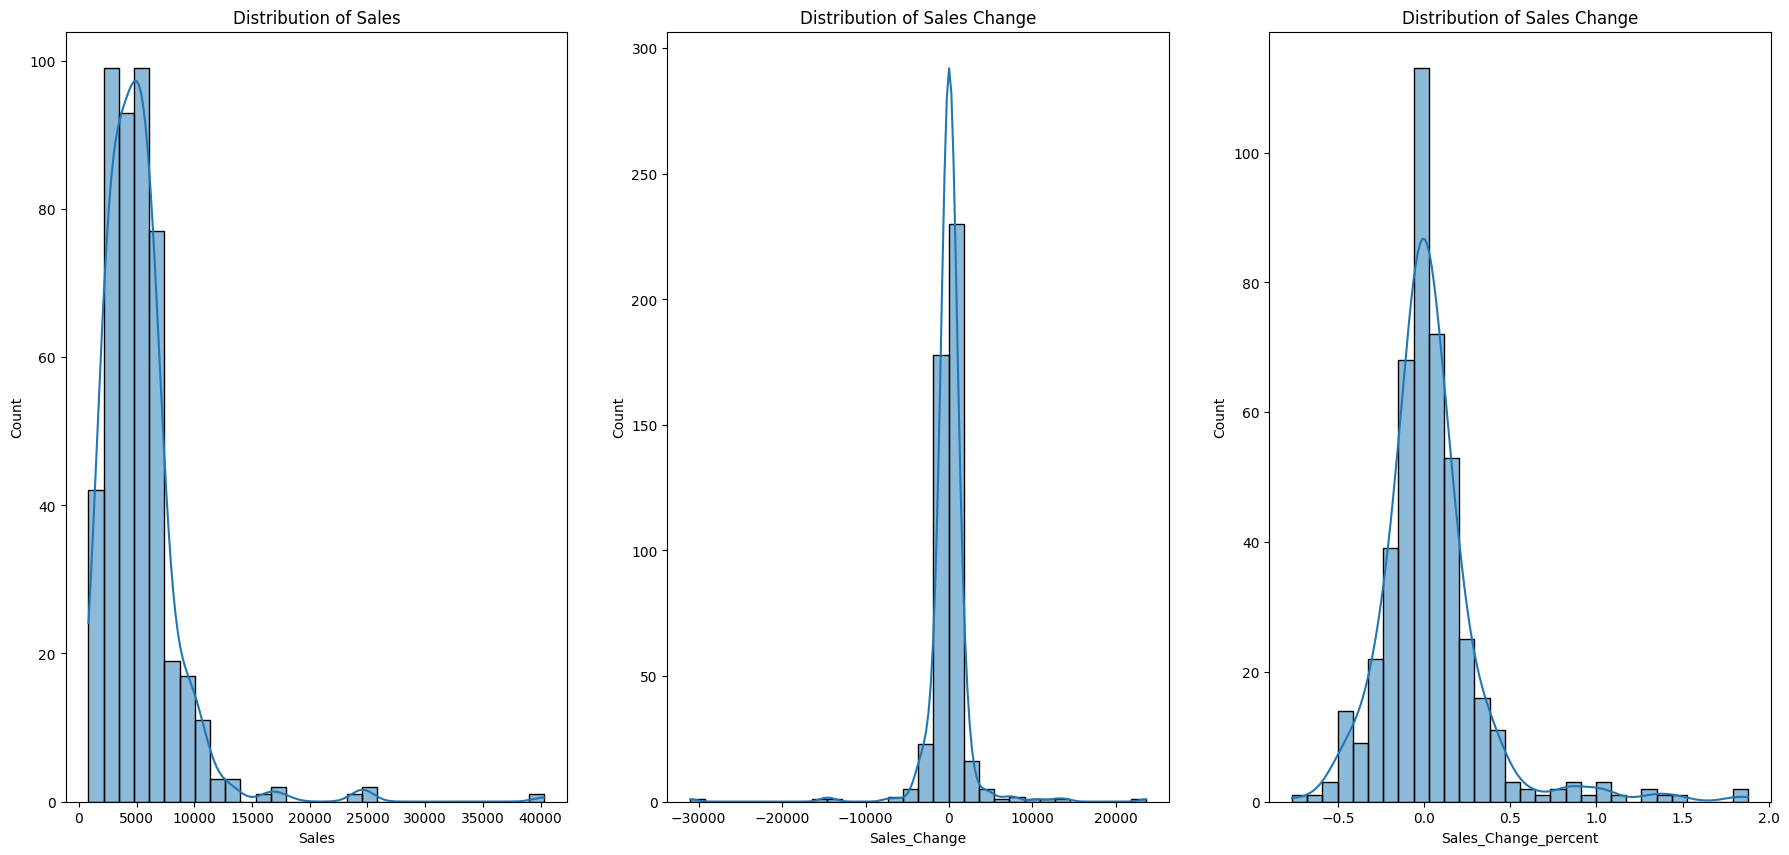

In [12]:
# distribution of data
plt.figure(figsize=(22, 10))

plt.subplot(1, 3, 1)
sns.histplot(data['Sales'], bins=30, kde=True)
plt.title('Distribution of Sales')

plt.subplot(1, 3, 2)
sns.histplot(data['Sales_Change'], bins=30, kde=True)
plt.title('Distribution of Sales Change')

plt.subplot(1, 3, 3)
sns.histplot(data['Sales_Change_percent'], bins=30, kde=True)
plt.title('Distribution of Sales Change')
plt.show()

# Data Normality Check

In [13]:
from scipy.stats import shapiro

In [14]:
def shapiro_test(data):
    stat, p = shapiro(data)
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample seems Gaussian (fail to reject H0)')
    else:
        print('Sample does not seem Gaussian (reject H0)')

In [15]:
shapiro_test(data['Sales'])
shapiro_test(data['Sales_Change'].iloc[1:])
shapiro_test(data['Sales_Change_percent'].iloc[1:])

Statistics = 0.721, p = 0.000
Sample does not seem Gaussian (reject H0)
Statistics = 0.520, p = 0.000
Sample does not seem Gaussian (reject H0)
Statistics = 0.826, p = 0.000
Sample does not seem Gaussian (reject H0)


In [16]:
# Try transforming data and testing again
data['Sales_Log'] = np.log(data['Sales'])
data['Sales_Sqrt'] = np.sqrt(data['Sales'])

In [17]:
shapiro_test(data['Sales_Log'])
shapiro_test(data['Sales_Sqrt'])

Statistics = 0.985, p = 0.000
Sample does not seem Gaussian (reject H0)
Statistics = 0.923, p = 0.000
Sample does not seem Gaussian (reject H0)


# Stationarity Check

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
result = adfuller(data['Sales'])

In [20]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is not stationary, may have trend or seasonality")
else:
    print("Series is stationary")

ADF Statistic: -5.885512
p-value: 0.000000
Series is stationary


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Series                470 non-null    object        
 1   Sales                 470 non-null    int64         
 2   WK_Num                470 non-null    int64         
 3   MMM                   470 non-null    object        
 4   Calendar Year         470 non-null    int64         
 5   Fiscal Year           470 non-null    int64         
 6   Sales_Change_percent  469 non-null    float64       
 7   Sales_Change          469 non-null    float64       
 8   Time                  470 non-null    datetime64[ns]
 9   Sales_Log             470 non-null    float64       
 10  Sales_Sqrt            470 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 40.5+ KB


# Time Series Decomposition

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [23]:
data_test = data.copy()
data_test.set_index('Time', inplace=True)

In [24]:
data_test = data_test.resample('W').sum()

In [25]:
decomposition = seasonal_decompose(data_test['Sales'], model='additive')

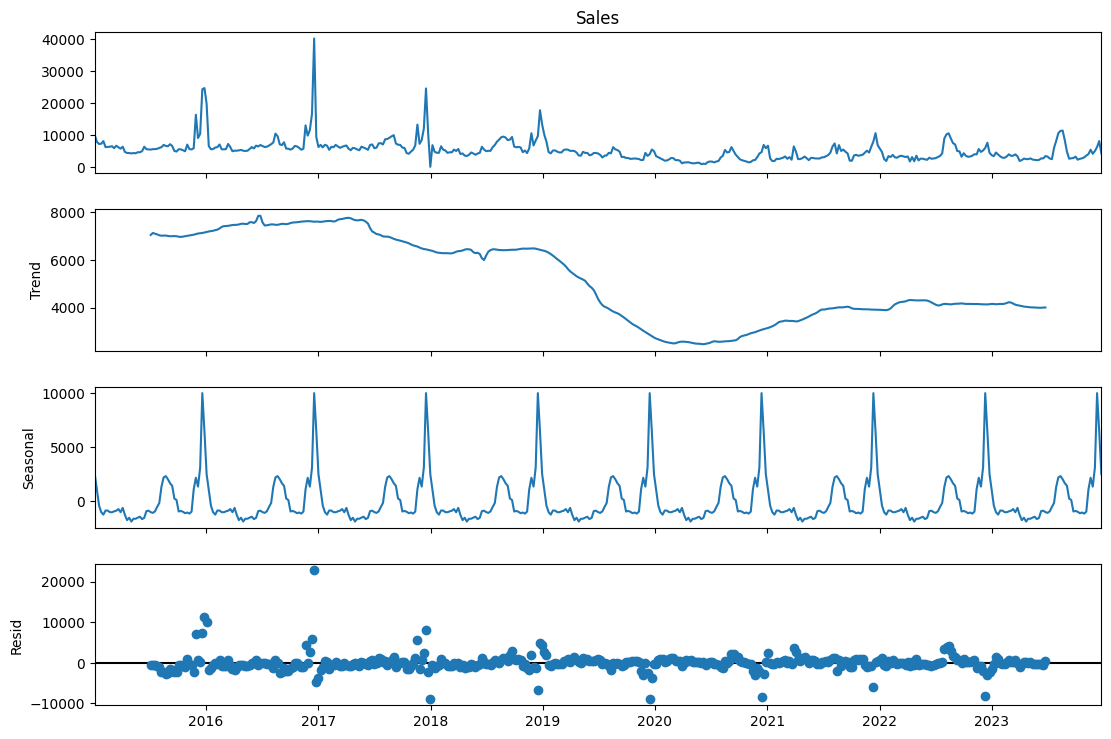

In [26]:
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

The trend component shows a decline starting from the year 2019, suggesting a long-term decrease in sales.
<br>
The seasonal component indicates a repeating pattern in each year, exhibiting strong seasonality near the year end which could be holiday (christmas) promotions/sales.
<br>
The residuals represent that parts that are not explained by the trend or seasonality, and have several large spikes.

In [27]:
residual = decomposition.resid.dropna()

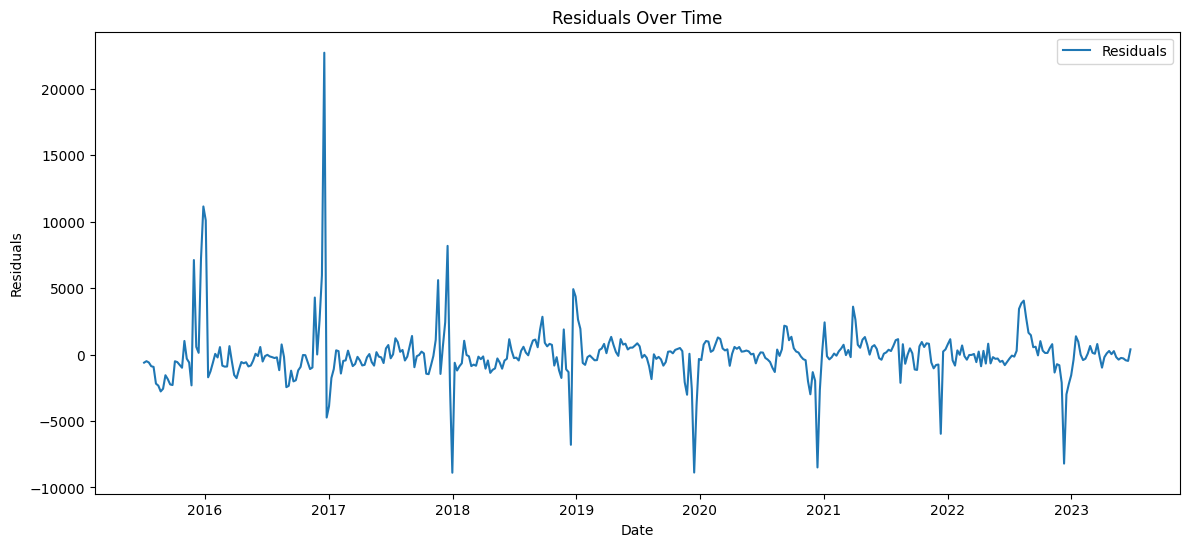

In [28]:
# Plot residuals
plt.figure(figsize=(14, 6))
plt.plot(residual.index, residual, label='Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

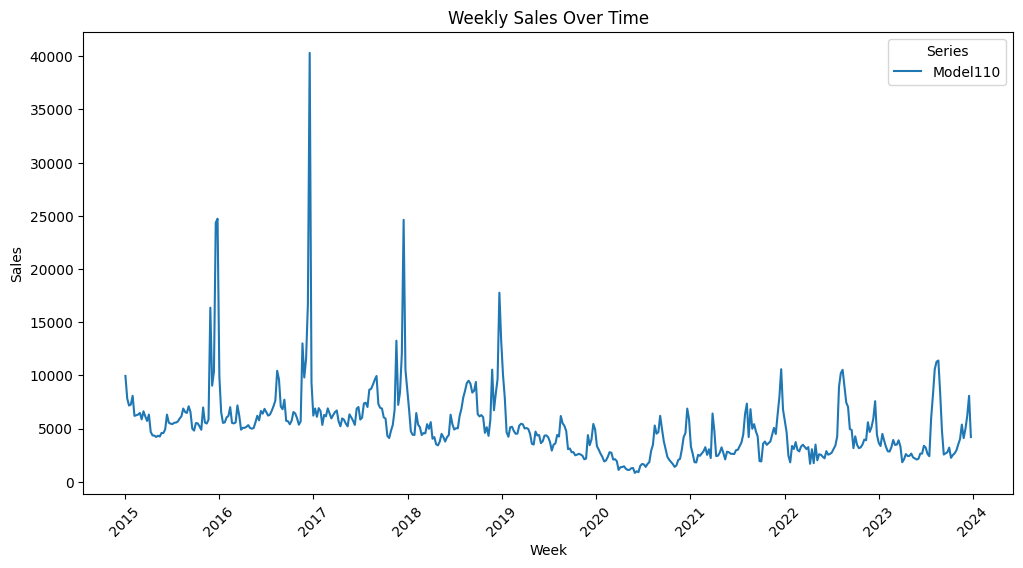

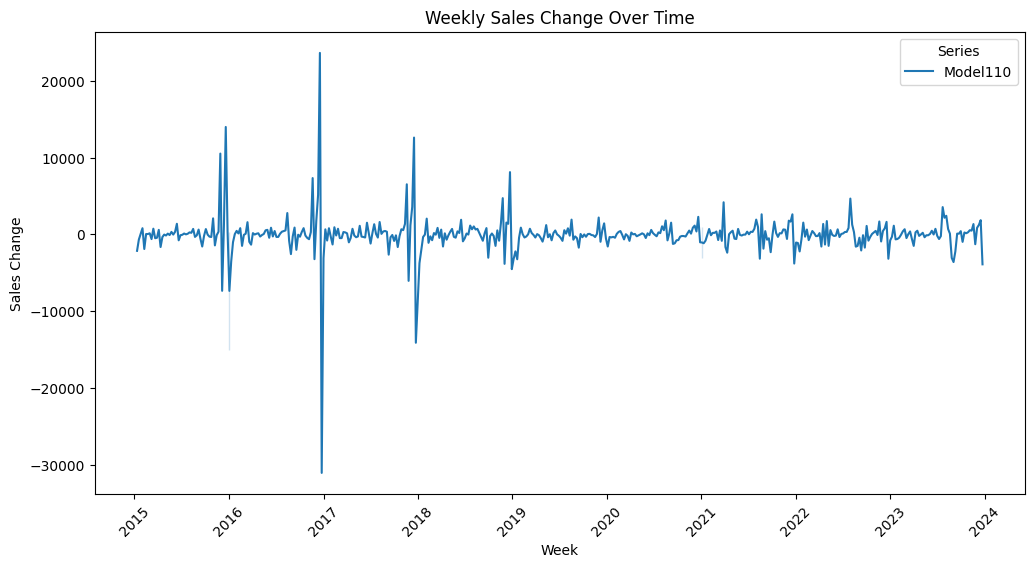

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Time', y='Sales', hue='Series', data=data)
plt.title('Weekly Sales Over Time')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time', y='Sales_Change', hue='Series', data=data)
plt.title('Weekly Sales Change Over Time')
plt.xlabel('Week')
plt.ylabel('Sales Change')
plt.xticks(rotation=45)
plt.show()

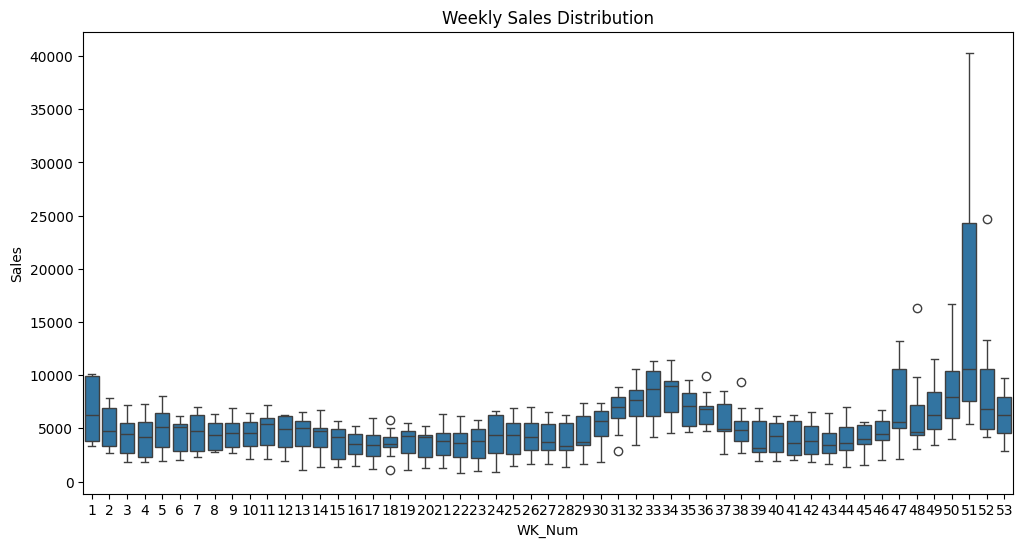

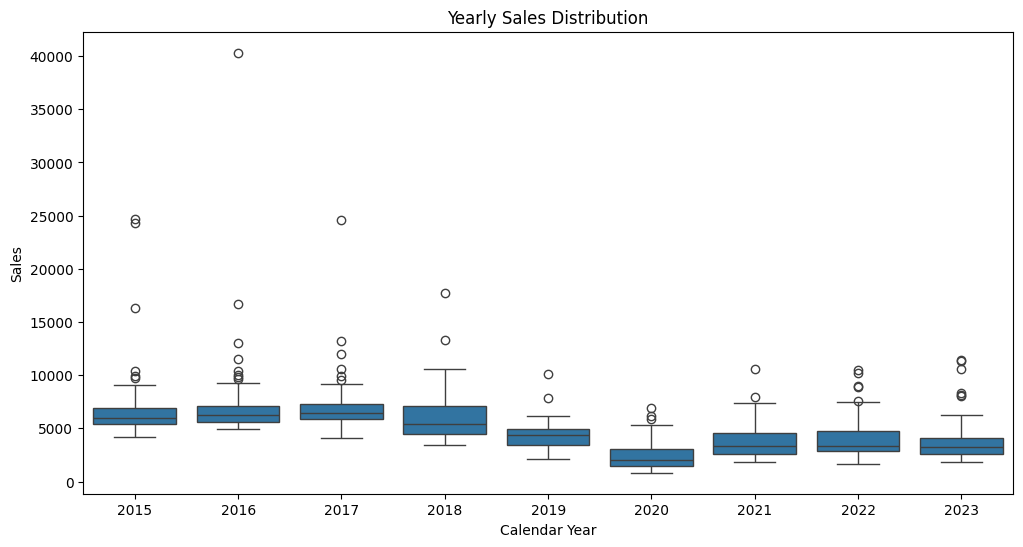

In [30]:
# Box plot for sales across different months
plt.figure(figsize=(12, 6))
sns.boxplot(x='WK_Num', y='Sales', data=data)
plt.title('Weekly Sales Distribution')
plt.show()

# Box plot for sales across different years
plt.figure(figsize=(12, 6))
sns.boxplot(x='Calendar Year', y='Sales', data=data)
plt.title('Yearly Sales Distribution')
plt.show()

In [31]:
data.head()

,Series,Sales,WK_Num,MMM,Calendar Year,Fiscal Year,Sales_Change_percent,Sales_Change,Time,Sales_Log,Sales_Sqrt
0,Model110,9948,1,JAN,2015,2014,NaN,NaN,2015-01-04,9.205127,99.739661
1,Model110,7821,2,JAN,2015,2014,-0.213812,-2127.0,2015-01-11,8.964568,88.436418
2,Model110,7163,3,JAN,2015,2014,-0.084132,-658.0,2015-01-18,8.876684,84.634508
3,Model110,7262,4,JAN,2015,2014,0.013821,99.0,2015-01-25,8.890411,85.217369
4,Model110,8080,5,JAN,2015,2014,0.112641,818.0,2015-02-01,8.997147,89.888820


In [32]:
# save as pickle file
data.to_pickle('data/Sales_data_cleaned.pkl')